<a href="https://colab.research.google.com/github/GiulioTrigila/MoonExample/blob/main/MoonExampleRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
##Moon example - Giulio Trigila - 2023
##The code implements Algorithm 1, appeared in "A generative flow model for conditional 
##sampling via optimal transport", in its basic form.  

##Discalimer: 
## 1) The code is far from being optimized. For instance, computing the pushforward kde (current in the code) for bandwidth selection
## is expensive and can be avoided by means of different bandwidth selection methods (e.g. median distance of the samples from the center of the kernel)
## 2) The parameters of the code were chosen using cross validation. They can be modified in diffrent ways:
## For instance it has been noticed that the calculation of the map may be faster when, rather than choosing at random
## the centers from the joint distribution, one chooses the centers from the joint and their relative kernels by using 
## a gaussian mixture model (GMM) on the samples drawn from  joint. 

In [86]:
from jax import grad, jit, vmap, jacfwd, lax
import jax.numpy as jnp
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.mixture import GaussianMixture
from scipy.ndimage import uniform_filter1d
import scipy
import time

#np.random.seed(seed=2734)

In [87]:
##Main functions used for the flow

@partial(jit, static_argnums=(3))
def RadFunc(X, center, bw, ss):
    dim = len(X)
    if ss==1: #Isotropic Kernels
      square_dist = jnp.sum((X - center)**2)
      r=jnp.sqrt(square_dist)

      ##Gaussian 
      #norml=jnp.sqrt((2*np.pi*bw**2)**dim)
      #rf=(1./norml)*jnp.exp(-0.5 * square_dist / bw**2)
      
      ##Erf 
      rf=r*lax.erf(r/bw) +(bw/jnp.sqrt(jnp.pi))*jnp.exp(-square_dist/(bw**2))
      
      ##Inverse multiquadric
      #rf=1/jnp.sqrt(1+(bw*r)**2)

    else: #Unisotropic Kernels
      aux=X-center
      innprod= aux.T @ jnp.linalg.solve(bw, aux)
      
      ##Gaussian Kernel
      #normlize=jnp.sqrt(jnp.linalg.det(bw))*(jnp.sqrt(2*jnp.pi)**dim)
      #rf=jnp.exp(-0.5*innprod)/normlize
      
      ##Erf
      r=jnp.sqrt(innprod)  
      rf=r*lax.erf(r) +(1/jnp.sqrt(jnp.pi))*jnp.exp(-innprod)  
  
    return rf

# Vectorize kernel
Kvmap = jit(vmap(RadFunc, in_axes=(0, None, None, None)), static_argnums=3)
# Vectorize wrt the centers and  bws
Kvmapctr = jit(vmap(Kvmap, in_axes=(None, 0, 0, None)), static_argnums=3)#return a NxNctr 

gradK      = jit(grad(RadFunc, argnums=(0)), static_argnums=3)#return a 1xd vector
grad_Kvmap = jit(vmap(gradK, in_axes=(0, None, None, None)), static_argnums=3)#return a Nxd vector

#Vectorize wrt the centers and  bws
grad_Kvmapctr = jit(vmap(grad_Kvmap, in_axes=(None, 0, 0, None), out_axes=(2)), static_argnums=3)#return a NxdxNctr tensor


def choosecenters(kde_current, kde_joint, Zcurrent, Zjoint, M, N, dim,ratio,nctr_joint,nctr_curr,w,wjoint):  
  ntot=nctr_joint+nctr_curr
  centers=jnp.zeros([ntot,dim])
  bws=jnp.zeros(ntot)

  center_idx_curr = np.random.choice(np.arange(0,M), nctr_curr,replace=False,p=w)# 
  center_idx_joint = np.random.choice(np.arange(0,N), nctr_joint,replace=False,p=wjoint)# 
  k=np.arange(nctr_curr)
  centers=centers.at[k,:].set(Zcurrent[center_idx_curr[k],:] + 0.0001) 
  j=np.arange(nctr_joint)
  centers=centers.at[nctr_curr+j,:].set(Zjoint[center_idx_joint[j],:] + 0.0001) 

  
  #Choose centers from product and joint in both cases at random
  rho_center=kde_current(centers[0:nctr_curr,:].T)
  mu_center=kde_joint(centers[nctr_curr:ntot,:].T)

  ratio_points=ratio
  out_curr=(ratio_points * (1./(rho_center+0.0000001)))**(1/dim)
  bws=bws.at[k].set(out_curr)
  out_joint=(ratio_points * (1./(mu_center+0.0000001)))**(1/dim)
  bws=bws.at[nctr_curr+j].set(out_joint)

  return centers,bws

@partial(jit, static_argnums=(5))
def computebeta(Zcurrent, Ztarget, centers, bws, lam,ss):
    #Vectorized code
    auxx=grad_Kvmapctr(Ztarget,centers,bws,ss) #grad_F_target
    auxG=jnp.mean(Kvmapctr(Zcurrent,centers,bws,ss).T,0)-jnp.mean(Kvmapctr(Ztarget,centers,bws,ss).T,0)

    aux2=jnp.tensordot(auxx,lamMat, axes=(1,1),precision='high')
    aux3=jnp.transpose(aux2,axes=[0,2,1]) #grad_lam_F_target
    aux4=-0.5*jnp.einsum('ijk,ijl->ikl',auxx,aux3,precision='high')
    
    auxH=jnp.mean(aux4,0)#Hess_beta
    betas = jnp.linalg.solve(auxH,auxG)
    betas =betas * jnp.min(jnp.array([epsilon/jnp.linalg.norm(betas), 1.0]))

    return betas

@partial(jit, static_argnums=(5))
def updatePositionlm(Zlag, centers, bws, betas, lam,ss): 
    M,dim=jnp.shape(Zlag) 
    Nctr,_=jnp.shape(centers)
    rhs_lm=jnp.zeros((M,dim))
   
    for k in range(Nctr):
      aux_rhs_lm=(betas[k] * grad_Kvmap(Zlag, centers[k,:], bws[k],ss))
      rhsk_lm=jnp.matmul(lamMat,aux_rhs_lm.T).T
      rhs_lm=rhs_lm+rhsk_lm
    return rhs_lm


@partial(jit, static_argnums=(5))
def updatePosition(Z, centers, bws, betas, lam,ss): 
    M,dim=jnp.shape(Z) 
    Nctr,_=jnp.shape(centers)
    rhs=jnp.zeros((M,dim))   
    for k in range(Nctr):
      aux_rhs=(betas[k] * grad_Kvmap(Z, centers[k,:], bws[k],ss))
      rhsk=jnp.matmul(lamMat,aux_rhs.T).T #enforce triangular cost
      rhs=rhs+rhsk
    return rhs


## Functions useful when choosing kernerls from the GMM of the target
# #Plot ellipsoid
# def ell(cov,center):
#     val, rot = np.linalg.eig(cov)
#     val = np.sqrt(val)
#     t = np.linspace(0, 2.0 * np.pi, 100)
#     xy = np.stack((np.cos(t), np.sin(t)), axis=-1)
#     return (rot @ (val * xy).T + np.reshape(center,(2,1)))

# def ComputeBandwidth(rho_center, mu_center, ratio_points, dim,itr, Nitr):
#     sig=Nitr/10
#     mfact=0.2 + 0.2/(1+np.exp((itr-(Nitr/2))/sig))
#     #points selected only based on rho_center
#     out=(ratio_points * (1./(rho_center+0.0000000001)))**(1/dim)
#     return out*mfact


# def choosecentersGM(Nctr,NctrGM,dim,Zcurrent,kde_current,kde_joint,ratio,itr,nIter,ctr_traker,ctrdist_mon):
#   # choose center
#   prcurr=1
#   choice=np.random.binomial(size=1, n=1, p= prcurr)#flip a coin 
#   if choice > 0.5: #choose center from the product with prob prcurr
#     ss=1
#     centers=jnp.zeros([Nctr,dim])
#     #center_idx_joint = np.random.choice(np.arange(0,N), Nctr,replace=False)# np.random.randint(N,size=3)
#     bws=jnp.zeros(Nctr)      
#     center_idx_cur=np.random.choice(np.arange(0,M), Nctr,replace=False,p=list(w)) 
    
#     for k in range(Nctr): #centers from current
#         #centers[k,:] = Zcurrent[center_idx_cur[k],:] + 0.000001
#         centers=centers.at[k,:].set(Zcurrent[center_idx_cur[k],:] + 0.0001) 
#         bw = ComputeBandwidth(kde_current(centers[k,:]), kde_joint(centers[k,:]), ratio, dim,itr,nIter)[0]
        
#         #importance sampling for the center
#         ctr_traker=ctr_traker.at[center_idx_cur[k]].set(ctr_traker[center_idx_cur[k]]+1)     
#         bws=bws.at[k].set(bw)      
#     ctrdist_mon=jnp.append(ctrdist_mon,pdist(centers))#monitor distance between centers

#   else: #choose centers from joint GM 
#     ss=0
#     Nctr=NctrGM
#     centers=ctrgm + 0.000001   
#     mf=mulfact(itr,nIter,1)
#     mult_fact=np.append(mult_fact,[itr,mf])
#     bws=mf*band

#   return centers,bws, ctr_traker,ctrdist_mon   

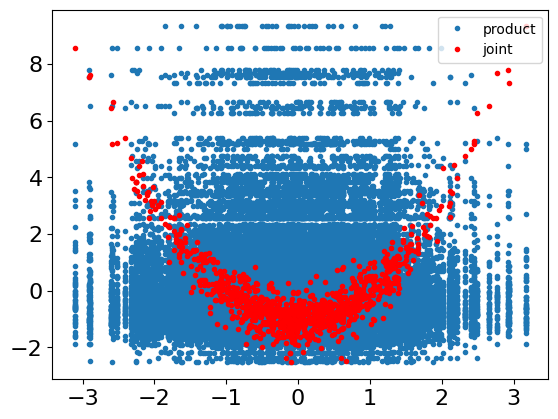

In [88]:
## Define  dataset: draw N samples from the joint and the product measures

N = 1000 #Number of samples from the joint
dim = 2  #space dim in which starting and target densities are defined

#Joint (target)
Zjoint=np.zeros([N,dim])
for pt in range(N):
  Zjoint[pt,0]=np.random.randn()
  Zjoint[pt,1]=0.5*np.random.randn()+Zjoint[pt,0]**2 -1

#Product measure (starting)
c1=np.zeros(N**2)
c2=np.zeros(N**2)
for k in range(N):
    c1[N*k:N+N*k]=Zjoint[k,0]*np.ones(N)
    c2[N*k:N+N*k]=Zjoint[:,1]
Zproductaux=np.stack((c1,c2),axis=1)

#Undersample the joint measure 
M=50*N
Zproduct=Zproductaux[np.random.choice(N**2, size=M, replace=False, p=None),:]

#Plot starting (product) and target (joint) samples
plt.plot(Zproduct[:,0], Zproduct[:,1], '.', label='product')
plt.plot(Zjoint[:,0], Zjoint[:,1], '.r', label='joint')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend()

#Re-scale initial points (it helps with the stability of the algorithm)
precfact=2
Zproduct[:,0]=Zproduct[:,0]/precfact

#Passive Lagrangian markers (lm) for the estimate of rho(x|ystr_lm)
LM=True 
if LM:
  Mlm=100000; #num of lm
  ystr_lm=1.5
  Zlm=np.zeros((Mlm,2))
  Zlm[:,0]=np.random.randn(Mlm)
  Zlm[:,1]=np.ones(Mlm)*ystr_lm
  Zlm[:,0]=Zlm[:,0]/precfact
  Zlm=jnp.array(Zlm)
  Zlm_start=Zlm

In [89]:
## Functions useful when choosing kernerls from the GMM of the   #nctr_joint=14; nctr_curr=6;

# ## Build the GMM using Zjoint
# covtype='full'
# NctrGM=5 #Numbers of GM components
# gm = GaussianMixture(n_components=NctrGM, covariance_type=covtype,random_state=0).fit(Zjoint)
# ctrgm=gm.means_
# band=np.zeros((NctrGM,2,2)) #works in 2d
# outband=30*gm.covariances_

# #Visualize the model
# plt.figure(figsize=(4,4))
# plt.plot(Zjoint[:,0], Zjoint[:,1], '.g', label='joint')
# plt.plot(ctrgm[:,0],ctrgm[:,1],'*r')

# if covtype=='diag':
#     for k in range(NctrGM):
#         band[k]=np.diag(outband[k,:])
# elif covtype=='full':
#     for k in range(NctrGM):
#         band[k]=outband[k]
# elif covtype=='tied':
#     for k in range(NctrGM):
#         band[k]=outband
# elif covtype=='spherical':
#     for k in range(NctrGM):
#         band[k]=outband[k]*np.eye(2)
# for k in range(NctrGM):
#   ellk= ell(band[k],ctrgm[k,:] )
#   plt.plot(*ellk)

In [90]:
# Inizialize parametes
nIter = 6000  # number of flow iterations
epsilon = 0.5 # cap on learning rate
ratio = 0.08 #ratio points captured by each kernel 
lam=1000 #penalization triangular cost

Zcurrent=jnp.array(Zproduct)
Zinitial=jnp.array(Zproduct)

#KDE joint
kde_joint = scipy.stats.gaussian_kde(Zjoint.T)

#KDE target
kde_current = scipy.stats.gaussian_kde(Zcurrent.T)
kdeinit=kde_current(Zcurrent.T)

In [91]:
invtemp=5 #importance sampling when choosing the centers from Zcurrent
w=np.ones(M)/M #weights importance sampling

auxj=np.exp(-invtemp*kde_joint(Zjoint.T))
wjoint=auxj/np.sum(auxj)

nctr_joint=8; nctr_curr=8; 
Nctr=nctr_curr+nctr_joint #tot num of centers

beta_mon=jnp.array([])
bw_mon=jnp.array([])
gr_mon=jnp.array([])
displ_mon=jnp.array([])

Jtot=jnp.ones(M)

ctr_traker=jnp.zeros([M,1])
ctrdist_mon=jnp.array([])

mult_fact=jnp.array([])

In [92]:
now = time.time()
ss=1
lamMat=jnp.diag(jnp.array([1,1,1,1,1/lam,1/lam,1/lam]),0)
lamMat=np.diag(np.array([1,1/lam]),0)
whenkde=np.array([int(nIter/10),int(nIter/4), int(nIter/2)])


for itr in range(nIter):

  # re-evaluate bandwidth
    if itr in whenkde:
      print('iteration ', itr,', updating kde')
      kde_current = scipy.stats.gaussian_kde(Zcurrent.T)
      aux=np.exp(-invtemp*kde_current(Zcurrent.T))
      w=aux/np.sum(aux)

    if itr % np.floor(nIter/10) == 0:
      print('iteration=', itr)
    #It may happens that the centers are positioned so to make the Hessian
    #ill-conditioned in this case, draw other centers at random
    betanotdone=True
    while betanotdone:   
      ##When using GMM     
      #centers, bws, ctr_traker,ctrdist_mon = choosecentersGM(Nctr,NctrGM,dim,Zcurrent,kde_current,kde_joint,ratio,itr,nIter,ctr_traker,ctrdist_mon)
      
      centers, bws = choosecenters(kde_current, kde_joint, Zcurrent, Zjoint, M, N, dim,ratio,nctr_joint,nctr_curr,w,wjoint)
      #Changing bandwidth along the way
      mm=(nIter/2); msig=(nIter/10)
      mfact=2 + 0/(1+np.exp((itr-mm)/msig))
      bws=mfact*bws  
 
      betas = computebeta(Zcurrent, Zjoint, centers, bws,lam,ss)
      if np.isnan(betas).any():
        print('choosing different centers')
        print('itr=',itr)
        #break 
      else: 
        betanotdone=False
    # update points
    rhs = updatePosition(Zcurrent, centers, bws, betas, lam,ss)
    if LM:
      rhs_lm = updatePositionlm(Zlm, centers, bws, betas, lam,ss)

    Zcurrent =Zcurrent + rhs
    if LM: #update position of passive Lagrangian markers 
      Zlm = Zlm + rhs_lm
      
    #To monitor some quantities
    beta_mon=jnp.append(beta_mon,jnp.linalg.norm(betas))
    bw_mon=np.append(bw_mon,bws)
    gr_mon=jnp.append(gr_mon,jnp.mean(jnp.sqrt(jnp.sum(rhs**2,axis=1))))
    displ_mon=jnp.append(displ_mon, jnp.mean((Zcurrent[:,0]-Zinitial[:,0])**2))


print('Execution time =',time.time() - now)
ndist=int(0.5*Nctr*(Nctr-1))
ctrdist_mon=jnp.reshape(ctrdist_mon,(int(jnp.size(ctrdist_mon)/ndist),ndist)) 

iteration= 0
choosing different centers
itr= 55
choosing different centers
itr= 287
choosing different centers
itr= 373
choosing different centers
itr= 451
choosing different centers
itr= 558
iteration  600 , updating kde
iteration= 600
choosing different centers
itr= 828
choosing different centers
itr= 861
choosing different centers
itr= 915
choosing different centers
itr= 955
iteration= 1200
choosing different centers
itr= 1297
choosing different centers
itr= 1357
iteration  1500 , updating kde
choosing different centers
itr= 1580
choosing different centers
itr= 1653
choosing different centers
itr= 1658
iteration= 1800
choosing different centers
itr= 2029
choosing different centers
itr= 2050
choosing different centers
itr= 2208
choosing different centers
itr= 2214
choosing different centers
itr= 2350
choosing different centers
itr= 2395
iteration= 2400
choosing different centers
itr= 2403
choosing different centers
itr= 2434
choosing different centers
itr= 2495
choosing different cen

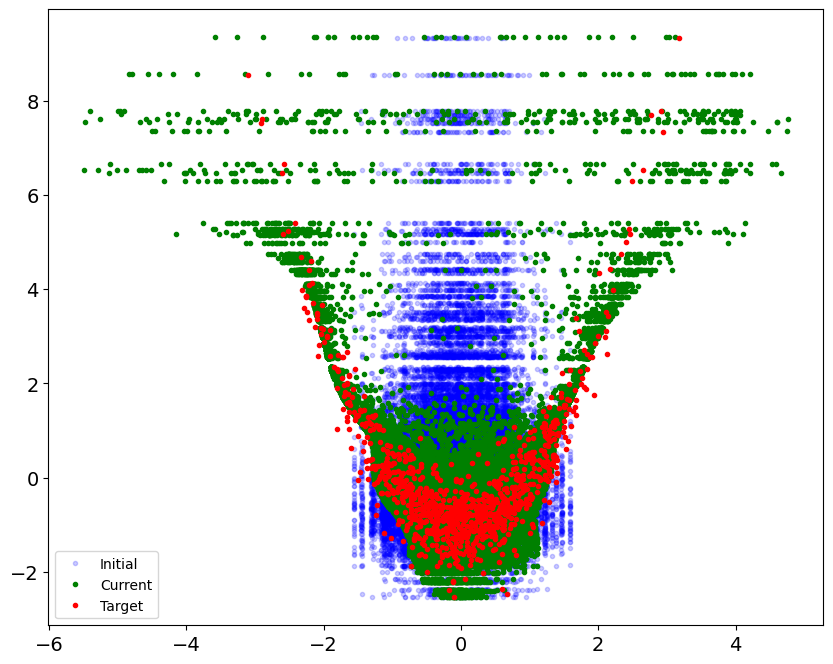

In [93]:
# plot points
plt.figure(figsize=(10,8))
plt.plot(Zinitial[:,0], Zinitial[:,1], '.b', label='Initial',alpha=0.2)
plt.plot(Zcurrent[:,0], Zcurrent[:,1], '.g', label='Current',alpha=1)
plt.plot(Zjoint[:,0], Zjoint[:,1], '.r', label='Target',alpha=1)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.legend()

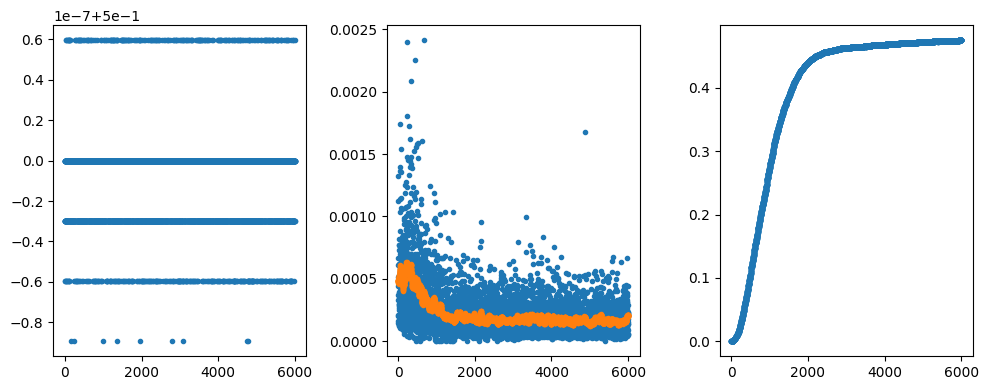

In [94]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,4))  
ax1.plot(beta_mon,'.')
ax2.plot(gr_mon,'.')
ax2.plot(scipy.ndimage.uniform_filter1d(gr_mon, size=50),'.')
ax3.plot(displ_mon,'.')
plt.tight_layout()

In [95]:
#Check the estimated conditional density rho(x|ystr)
ystr=ystr_lm; dy=0.05
#Choose one of the ystr in the training set for which we computed the map
indstr=np.argmin(np.abs(Zinitial[:,1]-ystr))
ystr=Zinitial[indstr,1]

print('ystar = ',ystr)
#kernel density estimation using Zcurrent
#Select all the mapped point in ystr-dy and ystr+dy
indstr= (Zcurrent[:,1] > ystr - dy ) & (Zcurrent[:,1] < ystr + dy)
spt= Zcurrent[indstr,:] #sample points
kernel=scipy.stats.gaussian_kde(spt[:,0])#, bw_method=None, weights=None)

#grid in x space on where to estimate the densities
xgrid=np.linspace(-3,3,500)
kdexgrd=kernel(xgrid)

#kde using raw data (for comparison)
#Select all the mapped point in ystr-dy and ystr+dy
indstr_raw= (Zjoint[:,1] > ystr - 2*dy ) & (Zjoint[:,1] < ystr + 2*dy)
spt_raw= Zjoint[indstr_raw,:] #sample pointstabak turner
kernel_raw=scipy.stats.gaussian_kde(spt_raw[:,0])#, bw_method=None, weights=None)
kde_raw=kernel_raw(xgrid)

#Compute theoretical conditional density (yet another comparison)
def pycx(x,ystr):
  s=0.5; s2=s**2;
  m=ystr-(x**2-1)
  return np.exp(-(m**2)/(2*s2))/np.sqrt(2*np.pi*s2)

def px(x):
  return np.exp(-(x**2)/(2))/np.sqrt(2*np.pi)

def pxcy(x,ystr):
  return pycx(x,ystr)*px(x)

nfact=scipy.integrate.quad(pxcy,-np.inf,+np.inf,args=ystr)
truthcd=pxcy(xgrid,ystr)/nfact[0]

ystar =  1.5034311


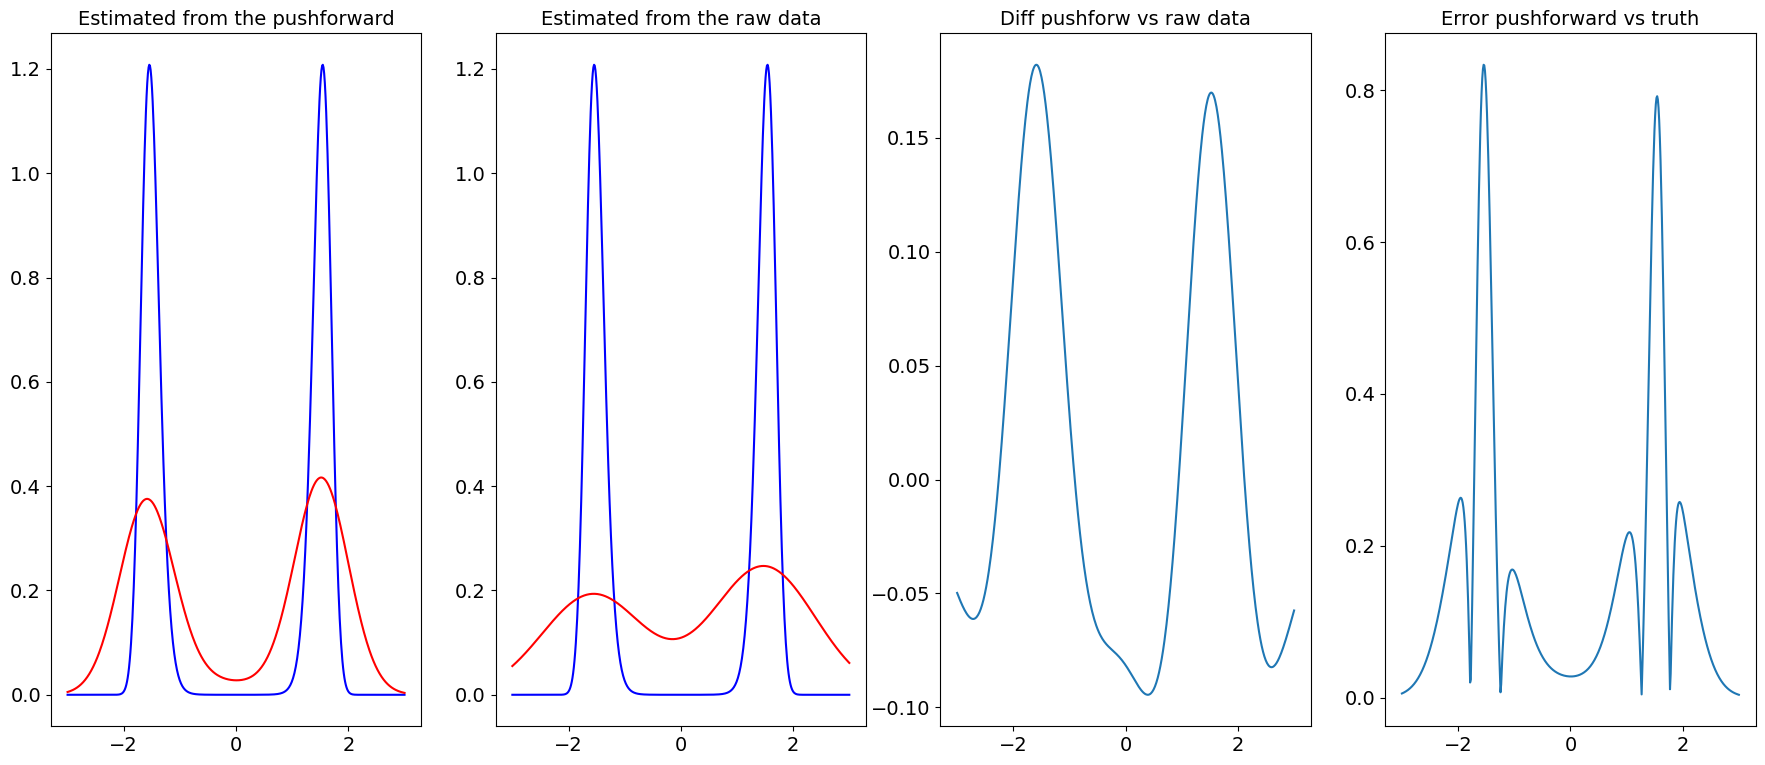

In [96]:
fig, axs = plt.subplots(1,4,figsize=(22,9))

axs[0].plot(xgrid,truthcd,'b') #true cond density rho(x|ystr)
axs[0].plot(xgrid,kdexgrd,'r')
axs[0].set_title('Estimated from the pushforward',fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].plot(xgrid,truthcd,'b')
axs[1].plot(xgrid,kde_raw,'r')
axs[1].set_title('Estimated from the raw data',fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

axs[2].plot(xgrid,kdexgrd-kde_raw)
axs[2].set_title('Diff pushforw vs raw data',fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=14)

axs[3].plot(xgrid,np.abs(kdexgrd-truthcd))
axs[3].set_title('Error pushforward vs truth',fontsize=14)
axs[3].tick_params(axis='both', which='major', labelsize=14)

In [97]:
#Estimate with Lagrangia markers
if LM:
  kernel_lm=scipy.stats.gaussian_kde(Zlm[:,0])#, bw_method=None, weights=None)

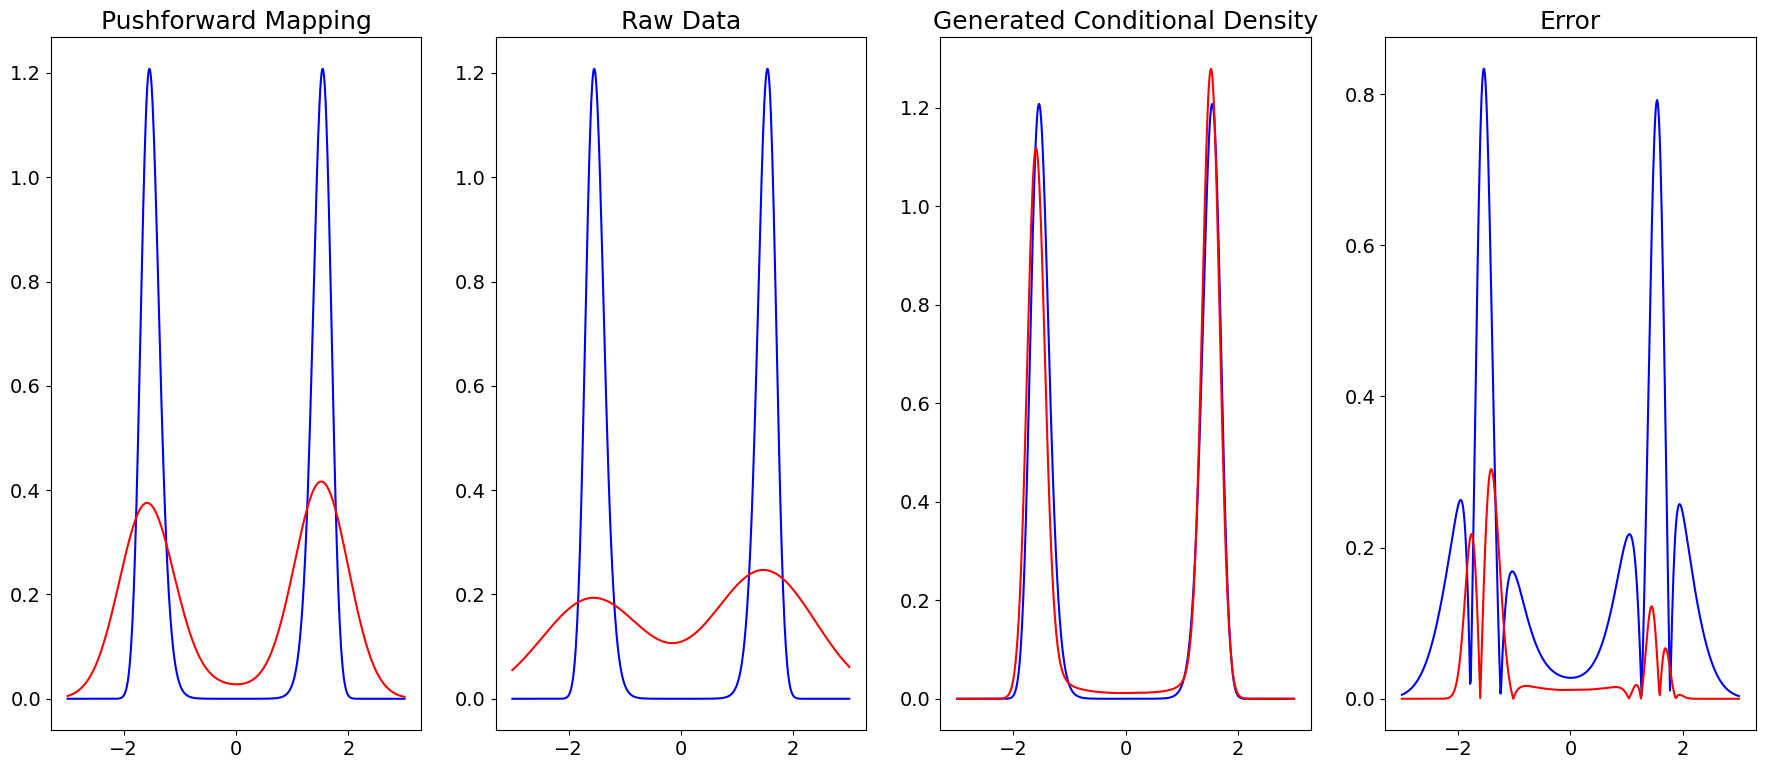

In [98]:
fig, axs = plt.subplots(1,4,figsize=(22,9))

axs[0].plot(xgrid,truthcd,'b') #true cond density rho(x|ystr)
axs[0].plot(xgrid,kdexgrd,'r')
axs[0].set_title('Pushforward Mapping',fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].plot(xgrid,truthcd,'b')
axs[1].plot(xgrid,kde_raw,'r')
axs[1].set_title('Raw Data',fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=14)


axs[2].plot(xgrid,truthcd,'b')
axs[2].plot(xgrid,kernel_lm(xgrid),'r')#cond estimated density using generated data#np.random.seed(seed=23)

axs[2].set_title('Generated Conditional Density',fontsize=18)
axs[2].tick_params(axis='both', which='major', labelsize=14)


axs[3].plot(xgrid,np.abs(kdexgrd-truthcd),'b') #error using pushforward points
axs[3].plot(xgrid,np.abs(kernel_lm(xgrid)-truthcd),'r') #error using generated data
axs[3].set_title('Error',fontsize=18)
axs[3].tick_params(axis='both', which='major', labelsize=14)
